<a href="https://colab.research.google.com/github/t-sano1222/TF2_NN/blob/master/regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# テーブルデータに関する単純な回帰問題の実装
参考
https://www.tensorflow.org/tutorials/keras/regression?hl=ja

In [1]:
# ペアプロットのためseabornを使用します
# !pip install seaborn

## install TF2

In [2]:
# from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0


## Load dataset(Boston)

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()

In [4]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['target'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [5]:
# sns.pairplot(df, hue="target")

## Split train-test

In [6]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [7]:
# sns.pairplot(df, hue="target")

In [8]:
train_stats = train_dataset.describe()
train_stats.pop("target")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,3.670339,8.977954,0.00632,0.08265,0.26838,3.47428,88.9762
ZN,405.0,11.067901,22.688396,0.00000,0.00000,0.00000,12.50000,95.0000
INDUS,405.0,11.097951,6.699157,0.74000,5.32000,9.69000,18.10000,27.7400
CHAS,405.0,0.069136,0.253999,0.00000,0.00000,0.00000,0.00000,1.0000
NOX,405.0,0.553098,0.115564,0.38500,0.44900,0.53800,0.62400,0.8710
RM,405.0,6.269768,0.690552,3.56100,5.87800,6.19300,6.61900,8.7800
AGE,405.0,68.241975,27.908527,2.90000,45.00000,76.50000,94.10000,100.0000
DIS,405.0,3.834098,2.162173,1.12960,2.07880,3.27210,5.21460,12.1265
RAD,405.0,9.474074,8.618564,1.00000,4.00000,5.00000,24.00000,24.0000
TAX,405.0,405.839506,164.057951,187.00000,284.00000,334.00000,666.00000,711.0000


## get labels

In [9]:
train_labels = train_dataset.pop('target')
test_labels = test_dataset.pop('target')

## Normalization (z transform)

In [10]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Build Model

In [11]:
def build_model():
  model = keras.Sequential([
    # Dense:Fully connected layer (OutputShape, Activation Function, (input shape))
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  # Set training process
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [12]:
model = build_model()

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## Check model

In [14]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.89069974],
       [-0.28994194],
       [-0.4806565 ],
       [-0.48494917],
       [-0.33074248],
       [-0.4060308 ],
       [-0.5422422 ],
       [-0.4070756 ],
       [-0.4194914 ],
       [-0.8080903 ]], dtype=float32)

## Train model

In [15]:
# print progress
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

## Visualize training

### table

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.437803,0.471238,0.437803,25.134130,3.088423,25.134130,995
996,0.612770,0.540060,0.612770,26.635529,3.115782,26.635529,996
997,0.467970,0.462120,0.467970,23.440674,2.951026,23.440674,997
998,0.608218,0.566324,0.608218,24.239466,3.003608,24.239466,998
999,0.517930,0.513390,0.517930,26.020218,3.102995,26.020218,999


### graph

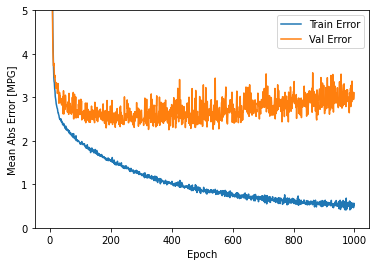

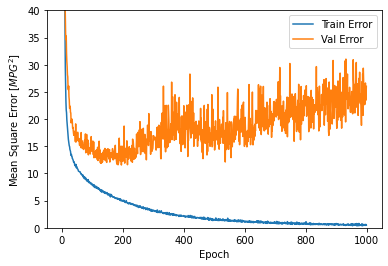

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()


plot_history(history)

## early stopping (今回はいらない？)


...........................................................................

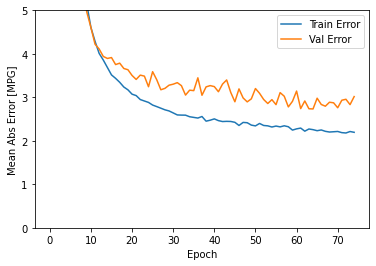

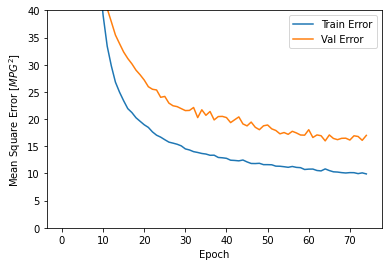

In [18]:
model = build_model()

# patience は改善が見られるかを監視するエポック数を表すパラメーター
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Test

In [19]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} target".format(mae))

4/4 - 0s - loss: 10.8349 - mae: 2.4104 - mse: 10.8349
Testing set Mean Abs Error:  2.41 target


## Prediction

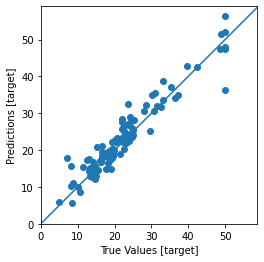

In [20]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [target]')
plt.ylabel('Predictions [target]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

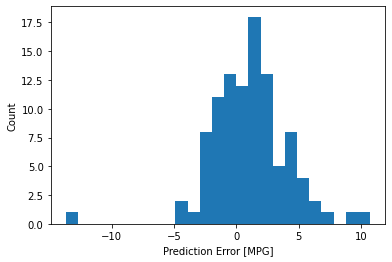

In [21]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")